In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
import torch.optim as optim

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Device: {device}")

Device: cpu


In [178]:
batch_size = 64

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
dataset = ImageFolder("data")

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset = ImageFolder("data", transform=train_transform)
val_dataset.dataset = ImageFolder("data", transform=val_test_transform)
test_dataset.dataset = ImageFolder("data", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

Number of images in training dataset: 70408
Number of images in validation dataset: 8801
Number of images in test dataset: 8802


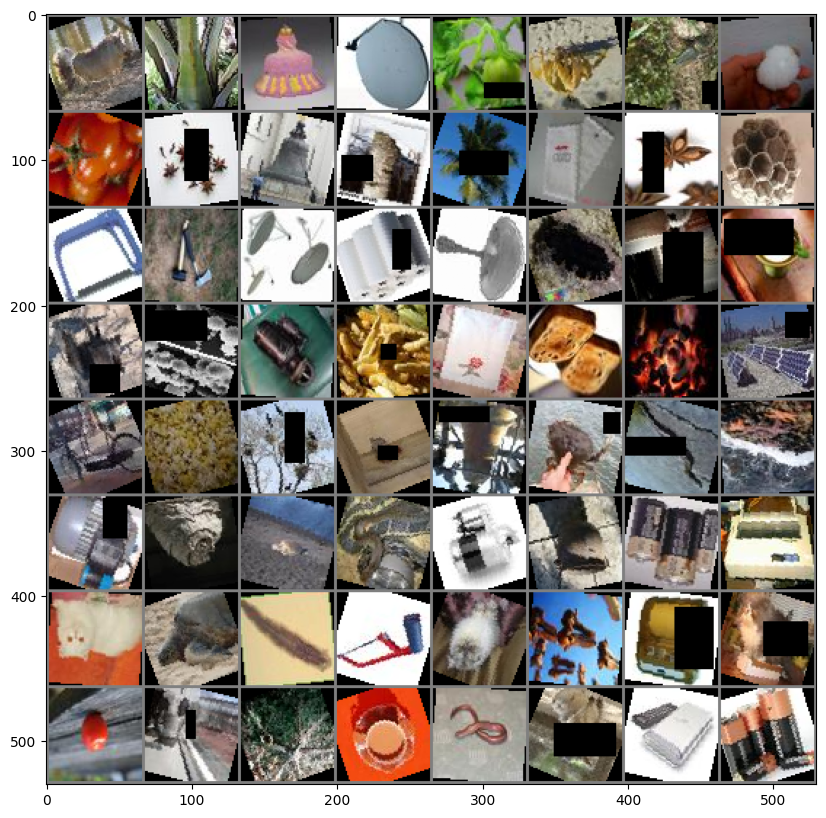

['swine', 'palm', 'acoustic', 'antenna', 'tomato', 'crab', 'frog', 'egg', 'tomato', 'spice', 'acoustic', 'birch', 'palm', 'towel', 'spice', 'nest', 'saw', 'hammer', 'antenna', 'towel', 'spoon', 'worm', 'pot', 'tea', 'swine', 'bacteria', 'motor', 'corn', 'towel', 'bread', 'carbon', 'antenna', 'bicycle', 'corn', 'nest', 'nest', 'acoustic', 'crab', 'snake', 'echinoderm', 'motor', 'nest', 'turtle', 'snake', 'motor', 'pot', 'battery', 'printer', 'cat', 'turtle', 'worm', 'saw', 'cat', 'spice', 'towel', 'cat', 'tomato', 'camera', 'echinoderm', 'tea', 'snake', 'kangaroo', 'antenna', 'battery']


In [180]:
plt.figure(figsize = (20,10))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(list(dataset.classes[labels[j]] for j in range(batch_size)))

In [31]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

In [164]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 50)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [165]:
classifier = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [166]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classifier (inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/5] loss: 1.799
[2/5] loss: 1.615
[3/5] loss: 1.540
[4/5] loss: 1.499
[5/5] loss: 1.468
Finished Training
